In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Make sure you have the latest versions of PyKE and oktopus installed on your system:

In [4]:
from pyke import SimpleKeplerPRF, PRFPhotometry, SceneModel
from pyke import KeplerTargetPixelFile
from pyke.utils import KeplerQualityFlags
from oktopus import UniformPrior

In [5]:
tpf = KeplerTargetPixelFile("ktwo203551698-c02_lpd-targ.fits",
                            quality_bitmask=None)

### Check out a random frame of the above target pixel file to see how it looks:

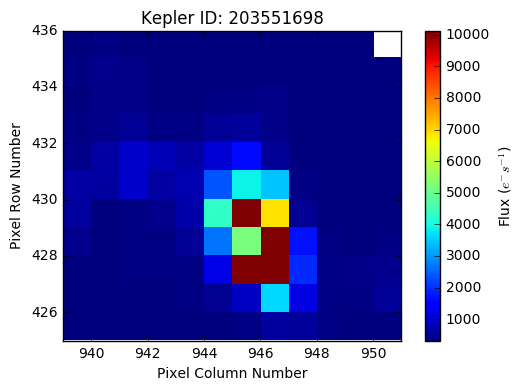

In [6]:
tpf.plot(frame=100,interpolation='nearest')

In [7]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

### This target pixel file contains two blended stars, so we need to create a model with two PRFs:

In [8]:
scene = SceneModel(prfs=2*[prf])

### Looking at the TPF image above, we need to provide some lower (lb) and upper bounds (ub) on the star fluxes, positions, and background levels. Syntax is [flux1, column1, row1, flux2, column2, row2, background].

In [9]:
prior = UniformPrior(lb=[2e3, 942, 427, 2e3, 941, 429, 200],
                    ub=[2e5, 947, 431, 2e5, 947, 434, 2000])

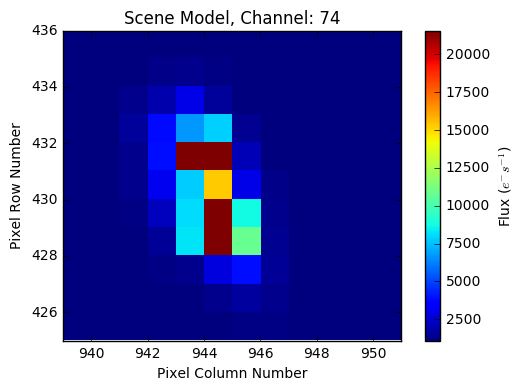

In [10]:
scene.plot(*prior.mean,interpolation='nearest')

In [11]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

### Check to see if the background has been measured and subtracted from this target pixel file. We see it's all nan's, so it hasn't. (If it had been, we might add it back in at this point.)

In [12]:
tpf.flux_bkg

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Now run the psf photometry model fit. This can take a bit of time:

In [13]:
results = phot.fit(tpf.flux)

  0%|          | 0/3856 [00:00<?, ?it/s]/Users/acody/anaconda2/lib/python2.7/site-packages/autograd/core.py:81: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
  0%|          | 13/3856 [00:01<06:30,  9.84it/s]/Users/acody/anaconda2/envs/astroconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  1%|▏         | 50/3856 [00:04<05:21, 11.85it/s]/Users/acody/anaconda2/envs/astroconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/acody/anaconda2/envs/astroconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 3856/3856 [09:03<00:00,  7.09it/s]


### Pull out the best fit fluxes, centroids, and background time series. Plot them.

In [14]:
flux_1 = results[:, 0]
xc_1 = results[:, 1]
yc_1 = results[:, 2]
flux_2 = results[:, 3]
xc_2 = results[:, 4]
yc_2 = results[:, 5]
bkg = results[:, -1]

(45000, 65000)

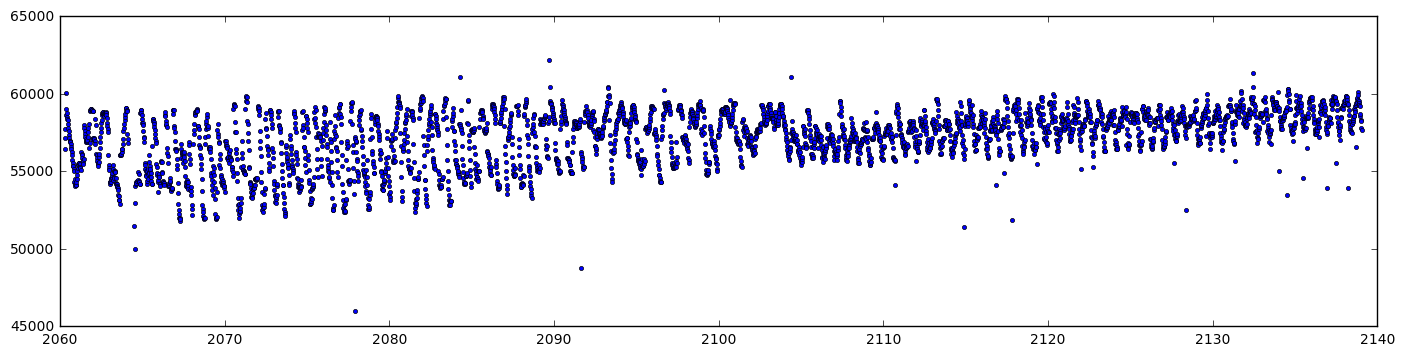

In [15]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_1, 'o', markersize=3)
plt.ylim(45000,65000)

(25000, 40000)

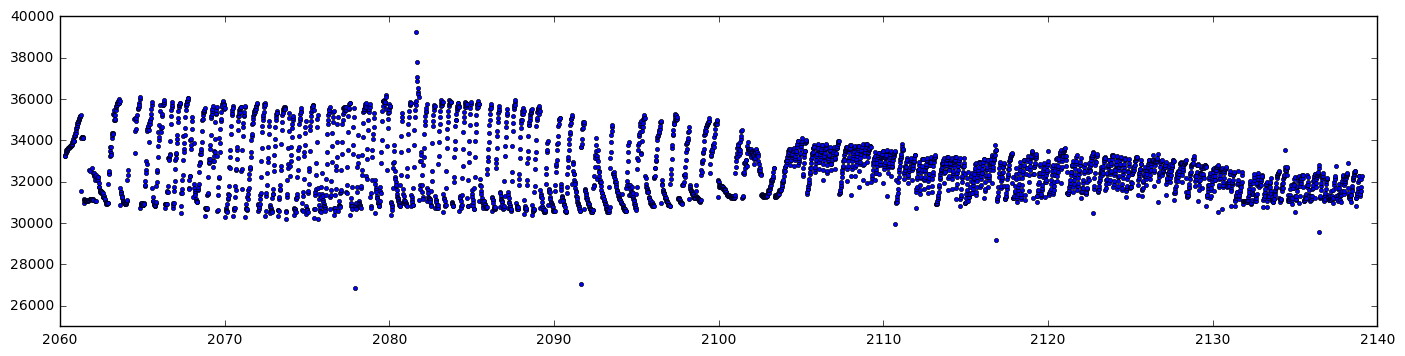

In [16]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_2, 'o', markersize=3)
plt.ylim(25000,40000)

(944, 947)

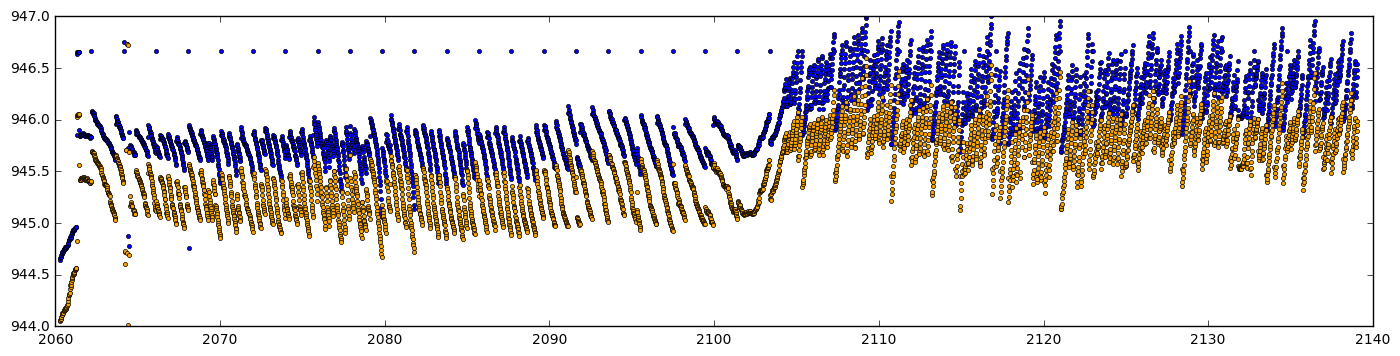

In [17]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, xc_1, 'o', markersize=3)
plt.plot(tpf.time, xc_2, 'o', color='orange',markersize=3)
plt.ylim(944,947)

(426.5, 430.5)

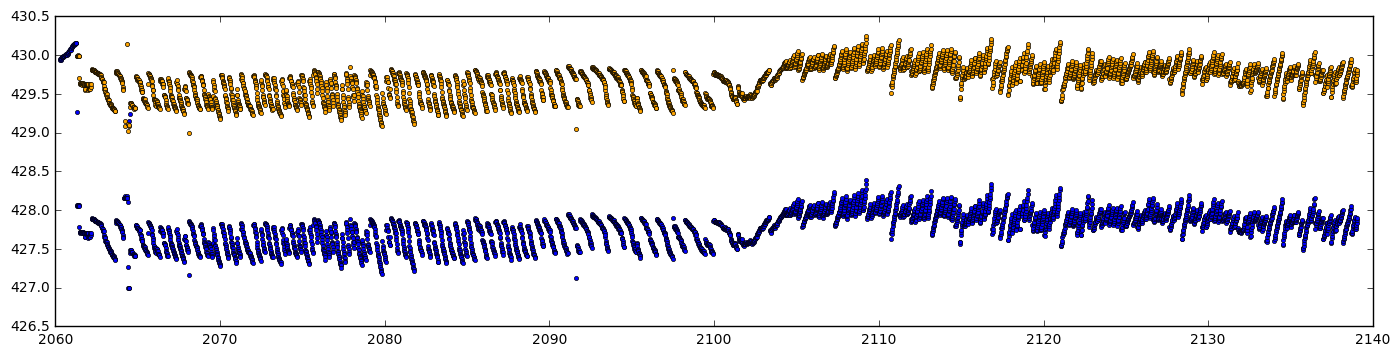

In [18]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, yc_1, 'o', markersize=3)
plt.plot(tpf.time, yc_2, 'o', color='orange',markersize=3)
plt.ylim(426.5,430.5)

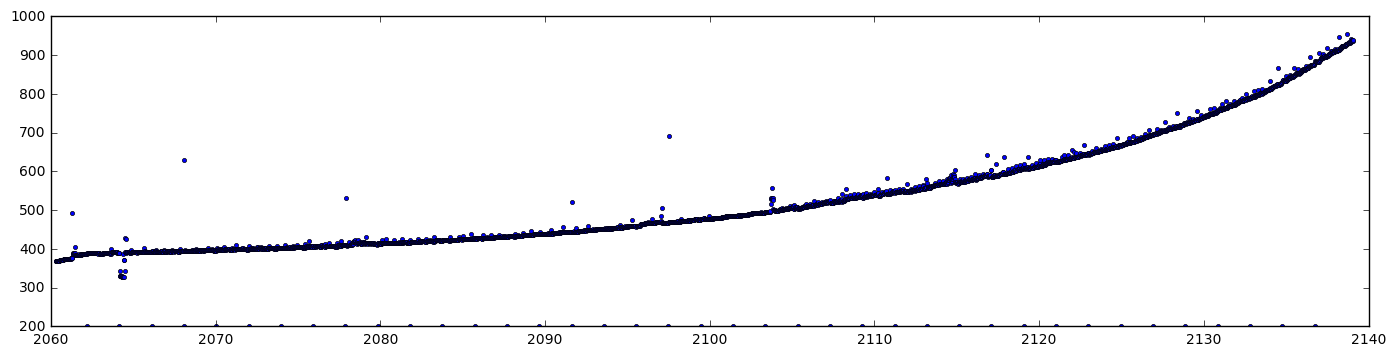

In [19]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, bkg, 'o', markersize=3)

### Write the data out to a file 

In [21]:
import astropy.io.ascii as ascii
from astropy.table import Table

In [ ]:
newtable = {'Dates': tpf.time, 'Cadences': tpf.cadenceno, 'Flux1': flux_2, 'Uncert1': np.sqrt(flux_2), 'Xpos': xc_2, 'Ypos': yc_2, 'Quality': tpf.quality}
ascii.write(newtable, 'EPIC_203551698_psf.dat', names=['Dates','Cadences', 'Flux1','Uncert1', 'Xpos', 'Ypos', 'Quality'], formats={'Dates': '%.8f', 'Cadences': '%5i', 'Flux1': '%.8f', 'Uncert1': '%.8f', 'Xpos': '%.5f','Ypos': '%.5f', 'Quality': '%5i'})                                                                                                                                   

In [ ]:
newtable = {'Dates': tpf.time, 'Cadences': tpf.cadenceno, 'Flux1': flux_1, 'Uncert1': np.sqrt(flux_1), 'Xpos': xc_1, 'Ypos': yc_1, 'Quality': tpf.quality}
ascii.write(newtable, 'EPIC_203551881_psf.dat', names=['Dates','Cadences', 'Flux1','Uncert1', 'Xpos', 'Ypos', 'Quality'], formats={'Dates': '%.8f', 'Cadences': '%5i', 'Flux1': '%.8f', 'Uncert1': '%.8f', 'Xpos': '%.5f','Ypos': '%.5f', 'Quality': '%5i'})                                                                                                                                   

### Run your favorite detrender here. SFF is usually sufficient, but not when the object has short-timescale variability like this one. We have run k2sc separately and input the results here.

In [22]:
tbl = Table.read('EPIC_203551698_psf_detrend.fits')
dates = tbl['time']
quality = tbl['quality']
flux = tbl['flux_1']
trendt = tbl['trend_t_1']
mflags = tbl['mflags_1']
trendp = tbl['trend_p_1']
xpos = tbl['x']
ypos = tbl['y']

In [ ]:
newfile = 'EPIC_203551698_psf_detrend.dat'
ascii.write(tbl,newfile)

In [23]:
tbl1 = Table.read('EPIC_203551881_psf_detrend.fits')
dates = tbl1['time']
quality = tbl1['quality']
flux1 = tbl1['flux_1']
trendt1 = tbl1['trend_t_1']
mflags1 = tbl1['mflags_1']
trendp1 = tbl1['trend_p_1']
xpos = tbl1['x']
ypos = tbl1['y']

In [ ]:
newfile1 = 'EPIC_203551881_psf_detrend.dat'
ascii.write(tbl1,newfile1)

### Compare with raw and aperture photometry results for this same object. You can see the effect of the detrending (before = cyan; after = red).

In [24]:
tbl2 = Table.read('EPIC_203551881_xy_ap1.0_2.0_3.0_4.0_fixbox_detrend.fits')
dates2 = tbl2['time']
quality = tbl2['quality']
flux2 = tbl2['flux_2']
trendt2 = tbl2['trend_t_2']
mflags2 = tbl2['mflags_2']
trendp2 = tbl2['trend_p_2']
xpos = tbl2['x']
ypos = tbl2['y']

(50000, 62000)

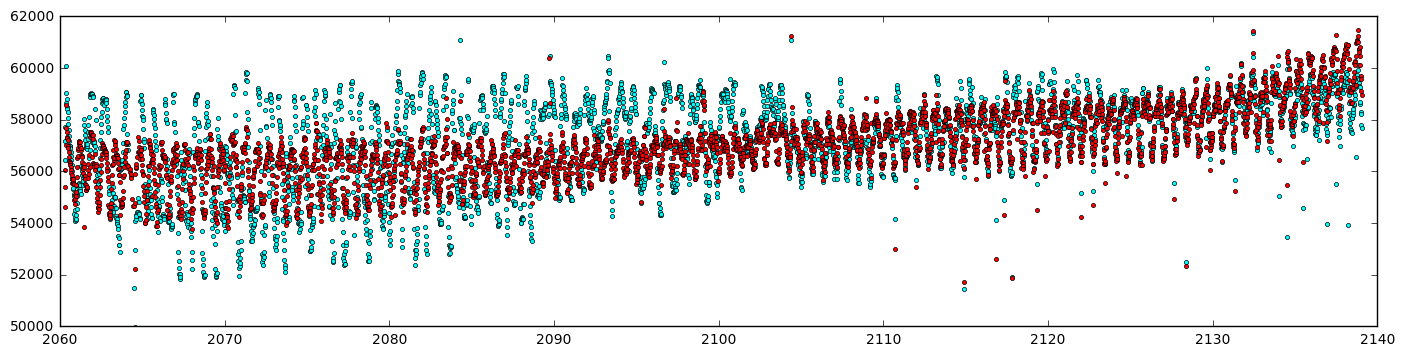

In [25]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux_1, 'o', color='cyan',markersize=3)
plt.plot(dates,flux1-trendp1+np.nanmedian(trendp1),'ro',markersize=3)
plt.ylim(50000,62000)

### Finally, compare psf photometry with aperture photometry. The former has much less of a long-term systematic. 

(50000, 80000)

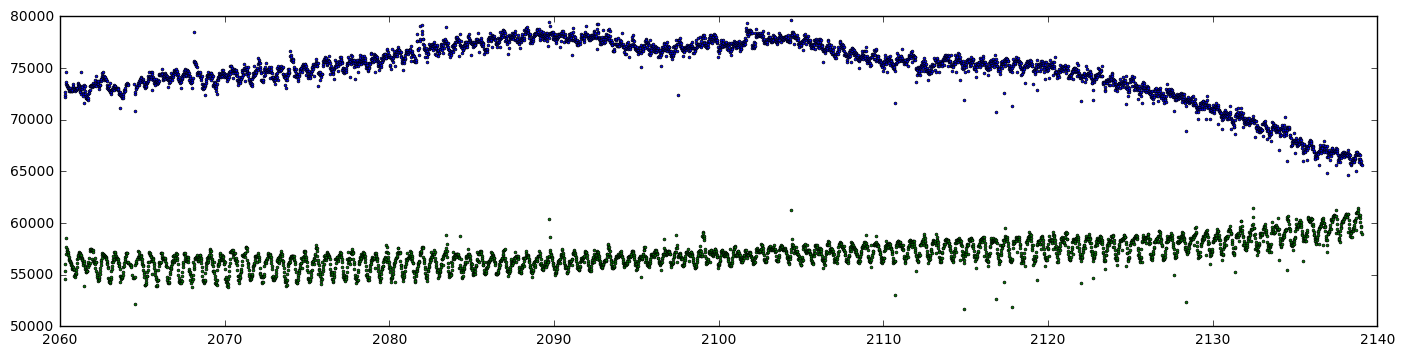

In [26]:
plt.figure(figsize=[17, 4])
plt.plot(dates2,flux2-trendp2+np.nanmedian(trendp2),'o',markersize=2)
plt.plot(dates, flux1-trendp1+np.nanmedian(trendp1), 'o', markersize=2)
plt.ylim(50000,80000)

(52000, 62000)

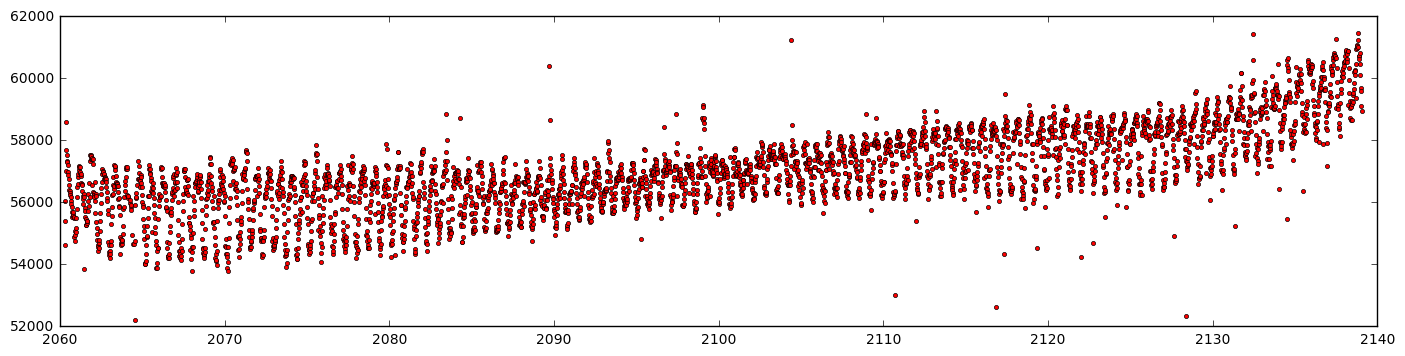

In [27]:
plt.figure(figsize=[17, 4])
plt.plot(dates,flux1-trendp1+np.nanmedian(trendp1),'ro',markersize=3)
plt.ylim(52000,62000)

### We can also check out the light curve of star #2 in the target pixel file. Looks like it has a longer timescale periodic variability.

(29000, 37000)

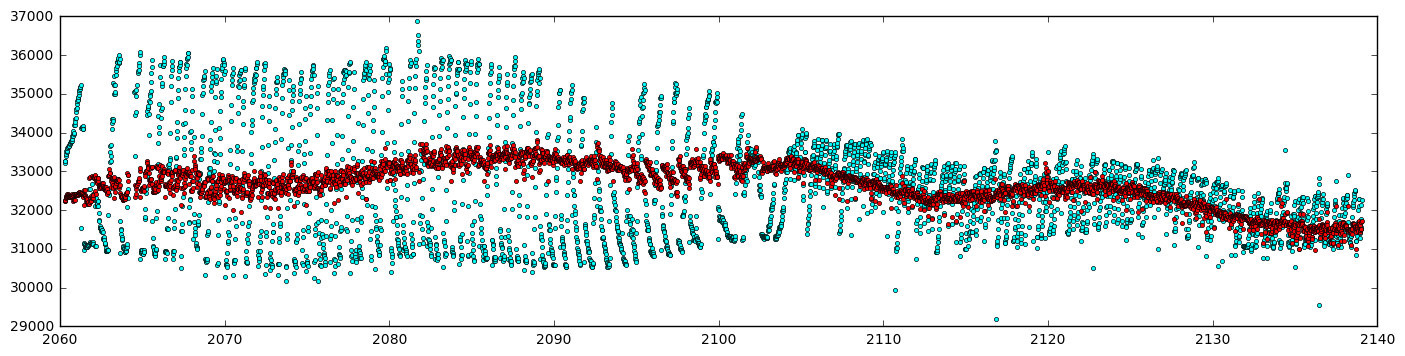

In [28]:
plt.figure(figsize=[17, 4])
good = np.where(mflags < 8)
plt.plot(tpf.time, flux_2, 'o', color='cyan',markersize=3)
plt.plot(dates[good],flux[good]-trendp[good]+np.nanmedian(trendp[good]),'ro',markersize=3)
plt.ylim(29000,37000)